# Experiment Setup 3: Optimisers
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
#### Import Modules

In [58]:
import pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from functools import lru_cache
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [59]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_WORD = 200

BATCH_SIZE = 128
EPOCHS = 5

#### Functions

In [60]:
def pickle_dataset(filename, dataset):
    file = open("{0}.pickle".format(filename),"wb")
    pickle.dump(dataset, file)
    file.close()

In [61]:
def round_pred(predictions):
    y_pred = [prediction.round() for prediction in predictions]
    
    return y_pred

In [62]:
def gen_confusion_matrix(y_true,y_pred):
    confusion_matrices={}

    for label_col in range(len(LABEL_FIELDS)):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]
        confusion_matrices[LABEL_FIELDS[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
    return confusion_matrices

In [63]:
def plot_precision_recall_curve(y_test,y_pred):
    # precision recall curve
    precision = dict()
    recall = dict()

    for i in range(len(LABEL_FIELDS)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

In [64]:
def plot_roc_curve(y_test, y_pred):
    # roc curve
    fpr = dict()
    tpr = dict()

    for i in range(len(LABEL_FIELDS)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                      y_pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()

In [65]:
def build_model(optimiser="adam"):
    model = Sequential()
    model.add(Embedding(len(corpus) + 1, 100, input_length=150))
    model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

    return model


#### Read in preprocessed test and train datasets

In [66]:
train = pickle.load(open("balanced_train.pickle", "rb"))
test = pickle.load(open("balanced_test.pickle", "rb"))

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

y_train = pickle.load(open("balanced_train_labels.pickle", "rb"))

x_sequences_test = tokenizer.texts_to_sequences(test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

y_test = pickle.load(open("balanced_test_labels.pickle", "rb"))

In [67]:
print(x_padded_train.shape)
print(y_train.shape)
print(x_padded_test.shape)
print(y_test.shape)

(78598, 150)
(78598, 6)
(10875, 150)
(10875, 6)


#### SGD

In [68]:
modelSGD = build_model(optimiser="SGD")
historySGD = modelSGD.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
553/553 [==============================] - 214s 387ms/step - loss: 0.5222 - accuracy: 0.1930 - val_loss: 0.3047 - val_accuracy: 0.0022
Epoch 2/5
553/553 [==============================] - 203s 366ms/step - loss: 0.2863 - accuracy: 0.3062 - val_loss: 0.1584 - val_accuracy: 0.9952
Epoch 3/5
553/553 [==============================] - 203s 367ms/step - loss: 0.2459 - accuracy: 0.4005 - val_loss: 0.1416 - val_accuracy: 0.9952
Epoch 4/5
553/553 [==============================] - 210s 380ms/step - loss: 0.2378 - accuracy: 0.4563 - val_loss: 0.1388 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 205s 371ms/step - loss: 0.2318 - accuracy: 0.4902 - val_loss: 0.1369 - val_accuracy: 0.9952


In [69]:
modelSGD.save("./optimiser_experiment/SGD_model")

INFO:tensorflow:Assets written to: ./optimiser_experiment/SGD_model\assets


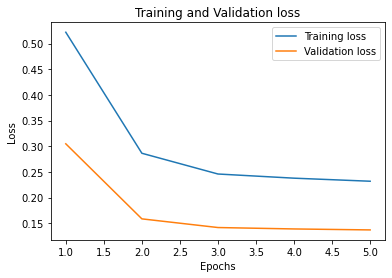

In [70]:
loss = historySGD.history['loss']
val_loss = historySGD.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

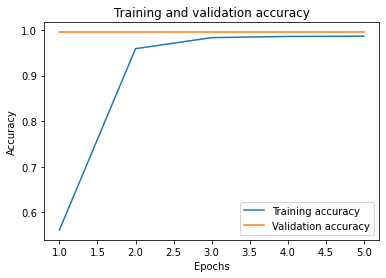

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [72]:
pred = modelSGD.predict(x_padded_test)

In [73]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


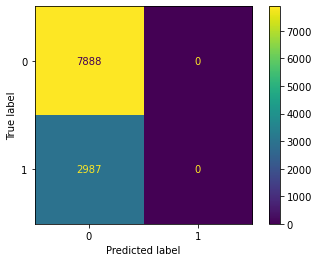

In [74]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


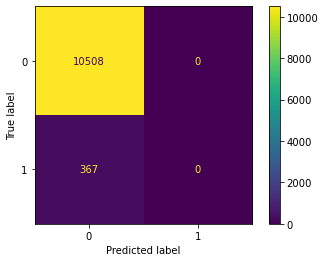

In [75]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


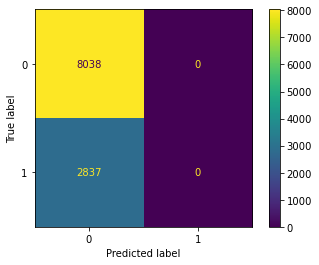

In [76]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


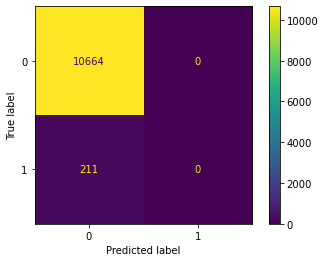

In [77]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


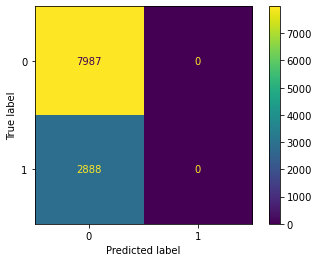

In [78]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


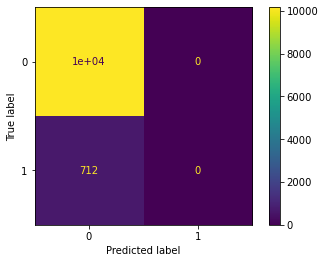

In [79]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

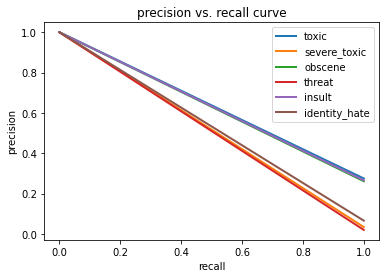

In [80]:
plot_precision_recall_curve(y_test,y_pred)

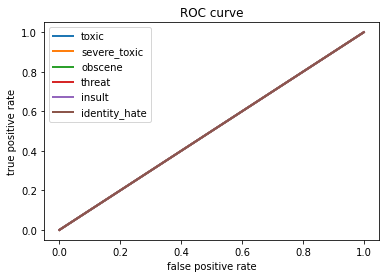

In [81]:
plot_roc_curve(y_test,y_pred)

In [82]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2987
           1       0.00      0.00      0.00       367
           2       0.00      0.00      0.00      2837
           3       0.00      0.00      0.00       211
           4       0.00      0.00      0.00      2888
           5       0.00      0.00      0.00       712

   micro avg       0.00      0.00      0.00     10002
   macro avg       0.00      0.00      0.00     10002
weighted avg       0.00      0.00      0.00     10002
 samples avg       0.00      0.00      0.00     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anacon

#### RMSprop

In [41]:
modelRMSprop = build_model(optimiser="RMSprop")
history = modelRMSprop.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
553/553 [==============================] - 222s 401ms/step - loss: 0.1725 - accuracy: 0.5617 - val_loss: 0.0518 - val_accuracy: 0.9952
Epoch 2/5
553/553 [==============================] - 229s 414ms/step - loss: 0.0811 - accuracy: 0.9591 - val_loss: 0.0484 - val_accuracy: 0.9952
Epoch 3/5
553/553 [==============================] - 224s 405ms/step - loss: 0.0753 - accuracy: 0.9833 - val_loss: 0.0488 - val_accuracy: 0.9952
Epoch 4/5
553/553 [==============================] - 230s 415ms/step - loss: 0.0720 - accuracy: 0.9860 - val_loss: 0.0486 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 220s 398ms/step - loss: 0.0705 - accuracy: 0.9865 - val_loss: 0.0477 - val_accuracy: 0.9952


In [42]:
modelRMSprop.save("./optimiser_experiment/RMSprop_model")

INFO:tensorflow:Assets written to: ./optimiser_experiment/RMSprop_model\assets


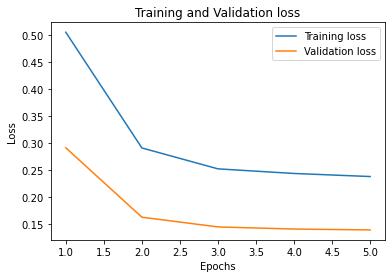

In [43]:
loss = historySGD.history['loss']
val_loss = historySGD.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

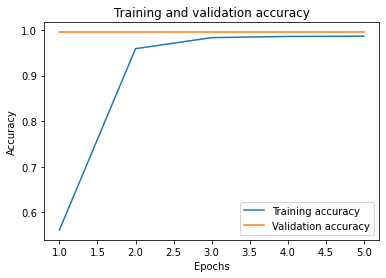

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [44]:
pred = modelSGD.predict(x_padded_test)

In [45]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


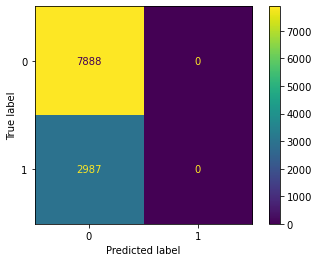

In [46]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


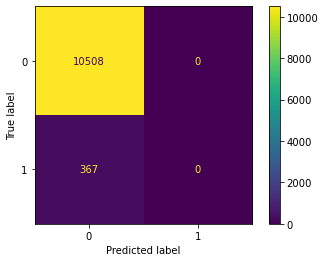

In [47]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


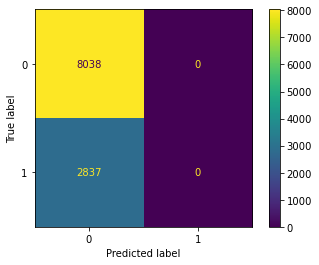

In [48]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


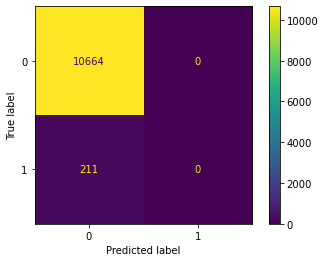

In [49]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


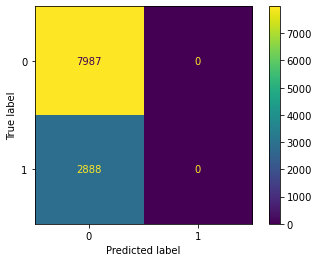

In [50]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


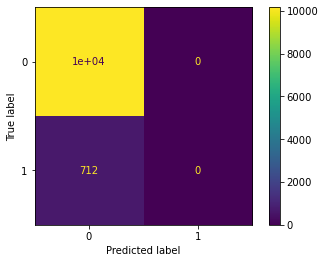

In [51]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

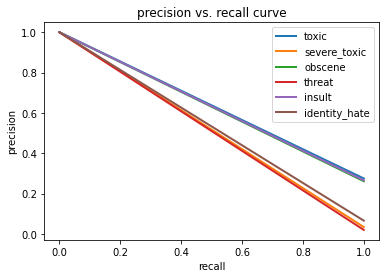

In [52]:
plot_precision_recall_curve(y_test,y_pred)

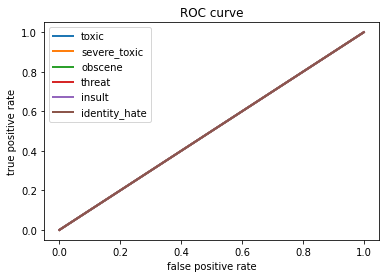

In [53]:
plot_roc_curve(y_test,y_pred)

In [54]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2987
           1       0.00      0.00      0.00       367
           2       0.00      0.00      0.00      2837
           3       0.00      0.00      0.00       211
           4       0.00      0.00      0.00      2888
           5       0.00      0.00      0.00       712

   micro avg       0.00      0.00      0.00     10002
   macro avg       0.00      0.00      0.00     10002
weighted avg       0.00      0.00      0.00     10002
 samples avg       0.00      0.00      0.00     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anacon

#### Discussion
This experiment has provided no improvement on the base model, by changing the optimizer from Adam to either SGD or RMSprop has caused the precision, recall and f1 scores to drop to 0. Although the training loss and accuracy appear to follow the trend in the base model, they do not provide an indication of the model's true performance. For example if the true label is [1,1,1,1,1,1] and the model predicts [1,1,1,0,0,0], the prediction would be evaluated as a miss (0%), where it actually correctly predicted 50% of the labels. Given that using these two optimizers have resulted in 0s for precision, recall and f1 scores, it appears that the Adam optimizer is best suited for multilabel classification and there was no need to change the other parameters and retrain to improve performance. This is supported by other multilabel projects online, which also use the Adam optimizer (https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/).